# Importacion de librerias

In [1]:
import os
import sys
root_dir = os.path.abspath(os.path.join(os.path.dirname('./pruebillas.ipynb'), '..'))
os.chdir(root_dir)

sys.path.insert(0, os.path.join(root_dir, 'src'))

In [2]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover

import pandas as pd
import pandas_ta as pandas_ta
import MetaTrader5 as mt5
import pandas as pd
from get_data import get_data
import pytz
from datetime import datetime
import talib as ta
import random
random.seed(42)

pd.options.display.float_format = '{:.5f}'.format



# Obtencion de datos

In [3]:
# establish connection to the MetaTrader 5 terminal
if not mt5.initialize():
    print("initialize() failed, error code =",mt5.last_error())
    quit()
 
# get all symbols
symbols = mt5.symbols_get()


groups = []
for symbol in symbols:
    group = symbol.path.split('\\')[0]
    if not group in groups:
        groups.append(group)
groups


['Forex_Indicator',
 'CryptoCross_grp',
 'Crypto_group',
 'Energies_group',
 'Forex_group',
 'Indices_group',
 'Stocks_group']

In [4]:
tickers = [symbol.path.split('\\')[1] for symbol in symbols if 'Indices_group' in symbol.path]
tickers

['AUS200m',
 'DE30m',
 'FR40m',
 'HK50m',
 'JP225m',
 'STOXX50m',
 'UK100m',
 'US30m',
 'US500m',
 'USTECm',
 'IN50m']

In [5]:

tickers = ['AUS200m','DE30m','FR40m','HK50m','JP225m','STOXX50m','UK100m','US30m','US500m','USTECm']

# Establecer la zona horaria a UTC
timezone = pytz.timezone("Etc/UTC")

# Crear objetos 'datetime' en zona horaria UTC
date_from = datetime(2014, 10, 1, tzinfo=timezone)
date_to = datetime(2024, 9, 1, tzinfo=timezone)

timeframes = [
    mt5.TIMEFRAME_M15,
    mt5.TIMEFRAME_M30,
    mt5.TIMEFRAME_H1,
    mt5.TIMEFRAME_H2,
    mt5.TIMEFRAME_H4,
]

symbols = get_data(tickers, timeframes, date_from, date_to)

MetaTrader5 package author:  MetaQuotes Ltd.
MetaTrader5 package version:  5.0.4288
AUS200m
AUS200m
AUS200m
AUS200m
AUS200m
DE30m
DE30m
DE30m
DE30m
DE30m
FR40m
FR40m
FR40m
FR40m
FR40m
HK50m
HK50m
HK50m
HK50m
HK50m
JP225m
JP225m
JP225m
JP225m
JP225m
STOXX50m
STOXX50m
STOXX50m
STOXX50m
STOXX50m
UK100m
UK100m
UK100m
UK100m
UK100m
US30m
US30m
US30m
US30m
US30m
US500m
US500m
US500m
US500m
US500m
USTECm
USTECm
USTECm
USTECm
USTECm


In [6]:
max_start_date = None
intervals_start_dates = {}

for interval in timeframes:
    for ticker in tickers:
        if not max_start_date or symbols[ticker][interval].index.min() > max_start_date:
            print(ticker)
            max_start_date = symbols[ticker][interval].index.min()
        
    intervals_start_dates[interval] = max_start_date

intervals_start_dates

AUS200m


{15: Timestamp('2021-10-27 17:15:00'),
 30: Timestamp('2021-10-27 17:15:00'),
 16385: Timestamp('2021-10-27 17:15:00'),
 16386: Timestamp('2021-10-27 17:15:00'),
 16388: Timestamp('2021-10-27 17:15:00')}

In [7]:
from pandas import Timestamp
limit_date_train = Timestamp('2022-10-01 00:00:00')
limit_date_train

Timestamp('2022-10-01 00:00:00')

# Test preliminar

In [8]:
class BbandsCross(Strategy):
    risk=10
    bbands_timeperiod = 50
    bband_std = 1.5
    sma_period = 200

    def init(self):
        
        self.sma = self.I(
            ta.SMA, self.data.Close, timeperiod=self.sma_period
        )

        self.upper_band, self.middle_band, self.lower_band = self.I(
            ta.BBANDS, self.data.Close, 
            timeperiod=self.bbands_timeperiod, 
            nbdevup=self.bband_std, 
            nbdevdn=self.bband_std
        )

    def next(self):
        actual_close = self.data.Close[-1]
        
        if self.position:
            if self.position.is_long:
                if crossover(self.data.Close, self.middle_band) or actual_close <= self.sma[-1]:
                    self.position.close()

            if self.position.is_short:
                if crossover(self.middle_band, self.data.Close) or actual_close >= self.sma[-1]:
                    self.position.close()

        else:

            if crossover(self.data.Close, self.lower_band) and actual_close > self.sma[-1]:
                self.buy(size=self.risk / 100)
                
            if crossover(self.upper_band, self.data.Close) and actual_close < self.sma[-1]:
                self.sell(size=self.risk / 100)
            

In [9]:
import itertools
import numpy as np
from sklearn.linear_model import LinearRegression

strategies = [
    BbandsCross, 
]

experiments = parameter_combinations = list(itertools.product(
    tickers, timeframes, strategies
))

performance = pd.DataFrame()

for ticker, interval, strategy in experiments:

    start_date = intervals_start_dates[interval]

    bt_train = Backtest(
        symbols[ticker][interval].loc[start_date:limit_date_train], 
        strategy,
        commission=7e-4,
        cash=100_000, 
        margin=1/30
    )
    
    stats = bt_train.run()
    
    equity_curve = stats._equity_curve['Equity'].values    
    x = np.arange(len(equity_curve)).reshape(-1, 1)
    reg = LinearRegression().fit(x, equity_curve)
    stability_ratio = reg.score(x, equity_curve)

    df_stats = pd.DataFrame({
        'strategy':[strategy.__name__],
        'ticker':[ticker],
        'interval':[interval],
        'stability_ratio':[stability_ratio],
        'return':[stats['Return [%]']],
        'final_eq':[stats['Equity Final [$]']],
        'drawdown':[stats['Max. Drawdown [%]']],
        'drawdown_duration':[stats['Max. Drawdown Duration']],
        'win_rate':[stats['Win Rate [%]']], 
        'sharpe_ratio':[stats['Sharpe Ratio']],
        'trades':[stats['# Trades']],
        'avg_trade_percent':[stats['Avg. Trade [%]']],
        'exposure':[stats['Exposure Time [%]']],
        'final_equity':[stats['Equity Final [$]']],
        'Duration':[stats['Duration']],

    })

    performance = pd.concat([performance, df_stats])

performance['return/dd'] = performance['return'] / -performance['drawdown']
performance['drawdown'] = -performance['drawdown']
performance['custom_metric'] = (performance['return'] / (1 + performance.drawdown)) * np.log(1 + performance.trades)

performance.drawdown_duration = pd.to_timedelta(performance.drawdown_duration)

performance.drawdown_duration = performance.drawdown_duration.dt.days



In [10]:

filter_performance = performance[
    (performance['return']>0) 
].sort_values(by=['drawdown_duration'], ascending=[True]).drop_duplicates(subset=['ticker'], keep='first')

portfolio = filter_performance.ticker.tolist()
timeframes = filter_performance.interval.values.tolist()

display(filter_performance)

# portfolio

,strategy,ticker,interval,stability_ratio,return,final_eq,drawdown,drawdown_duration,win_rate,sharpe_ratio,trades,avg_trade_percent,exposure,final_equity,Duration,return/dd,custom_metric
0,Bbands,US30m,16388,0.07883,13.12795,113127.95448,10.41105,90,54.54545,0.57995,11,0.50648,14.24639,113127.95448,337 days 08:00:00,1.26096,2.85878
0,Bbands,HK50m,15,0.59926,23.92392,123923.92325,18.79292,106,57.83784,0.92418,185,0.04209,11.02149,123923.92325,338 days 02:30:00,1.27303,6.31642
0,Bbands,USTECm,16386,0.10838,10.60851,110608.51273,19.38452,107,52.38095,0.29200,21,0.22341,8.96018,110608.51273,337 days 10:00:00,0.54727,1.60864
0,Bbands,FR40m,16388,0.02930,4.85383,104853.82690,15.35208,117,46.66667,0.26987,15,0.12577,8.99654,104853.82690,337 days 08:00:00,0.31617,0.82299
0,Bbands,AUS200m,16388,0.26489,7.62421,107624.21160,12.27213,168,76.92308,0.56399,13,0.21069,9.16193,107624.21160,337 days 08:00:00,0.62126,1.51601
0,Bbands,US500m,16388,0.16951,10.38683,110386.82562,26.12753,172,50.00000,0.33218,14,0.30856,14.72815,110386.82562,337 days 08:00:00,0.39754,1.03688
0,Bbands,UK100m,16385,0.46926,3.90707,103907.06771,14.31846,189,62.00000,0.23492,50,0.03046,10.02571,103907.06771,337 days 10:00:00,0.27287,1.00284
0,Bbands,JP225m,16386,0.04145,1.87604,101876.03509,16.37248,202,62.50000,0.12187,16,0.06468,7.43424,101876.03509,337 days 10:00:00,0.11458,0.30596


In [11]:
# for ticker, interval in zip(portfolio, timeframes):
#     bt_train = Backtest(
#         symbols[ticker][interval].loc[start_date:limit_date_train], 
#         Bbands,
#         commission=7e-4,
#         cash=100_000, 
#         margin=1/30
#     )

#     stats = bt_train.run()
#     bt_train.plot(filename=f'./{ticker}.html', resample=False)

# WFO

In [4]:
import numpy as np
np.arange(1, 3.2, 0.2)

array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ])

In [12]:
from utils import walk_forward, plot_full_equity_curve

def optim_func_2(stats):
    equity_curve = stats._equity_curve['Equity'].values    
    x = np.arange(len(equity_curve)).reshape(-1, 1)
    reg = LinearRegression().fit(x, equity_curve)
    stability_ratio = reg.score(x, equity_curve)
    
    return (stats['Return [%]'] /  (1 + (-1*stats['Max. Drawdown [%]']))) * np.log(1 + stats['# Trades']) * stability_ratio
    

stats_per_symbol = {}
lookback_bars = 1000
validation_bars = 250
warmup_bars = 200

wfo_performance = pd.DataFrame()
for ticker, interval in zip(['US30m', 'USTECm'], [16388, 16386]):
    
    # print(ticker, interval)

    params = {
        'bband_std' : list(np.arange(1, 3, 0.2)),
        'maximize': optim_func_2
    }

    wfo_stats = walk_forward(
        BbandsCross,
        symbols[ticker][interval], 
        lookback_bars=lookback_bars,
        validation_bars=validation_bars,
        warmup_bars=warmup_bars, 
        params=params,
        commission=7e-4, 
        margin=1/30, 
        cash=100_000,
        verbose=False
    )
    
    stats_per_symbol[ticker] = {}
    stats_per_symbol[ticker][interval] = wfo_stats
    
    df_equity = wfo_stats['_equity']
    
    plot_full_equity_curve(df_equity, title=f'{ticker}, {interval}')
    
    # Calculo el stability ratio
    x = np.arange(df_equity.shape[0]).reshape(-1, 1)
    reg = LinearRegression().fit(x, df_equity.Equity)
    stability_ratio = reg.score(x, df_equity.Equity)

    # Extraigo metricas
    df_stats = pd.DataFrame({
        'strategy':[strategy.__name__],
        'ticker':[ticker],
        'interval':[interval],
        'stability_ratio':[stability_ratio],
        'return':[wfo_stats['Return [%]']],
        'final_eq':[wfo_stats['Equity Final [$]']],
        'drawdown':[wfo_stats['Max. Drawdown [%]']],
        'drawdown_duration':[wfo_stats['Max. Drawdown Duration']],
        'win_rate':[wfo_stats['Win Rate [%]']], 
        'sharpe_ratio':[wfo_stats['Sharpe Ratio']],
        'trades':[wfo_stats['# Trades']],
        'avg_trade_percent':[wfo_stats['Avg. Trade [%]']],
        'exposure':[wfo_stats['Exposure Time [%]']],
        'final_equity':[wfo_stats['Equity Final [$]']],
        'Duration':[wfo_stats['Duration']],

    })

    wfo_performance = pd.concat([wfo_performance, df_stats])

wfo_performance['return/dd'] = wfo_performance['return'] / -wfo_performance['drawdown']
wfo_performance['drawdown'] = -wfo_performance['drawdown']
wfo_performance['custom_metric'] = (wfo_performance['return'] / (1 + wfo_performance.drawdown)) * np.log(1 + wfo_performance.trades)

wfo_performance.drawdown_duration = pd.to_timedelta(wfo_performance.drawdown_duration)
wfo_performance.drawdown_duration = wfo_performance.drawdown_duration.dt.days

wfo_performance.sort_values(by='return/dd', ascending=False)

,strategy,ticker,interval,stability_ratio,return,final_eq,drawdown,drawdown_duration,win_rate,sharpe_ratio,trades,avg_trade_percent,exposure,final_equity,Duration,return/dd,custom_metric
0,Bbands,US30m,16388,0.89070,22.41874,122418.74186,4.71606,177,76.47059,0.92123,17,0.43893,3.70121,122418.74186,1038 days 00:00:00,4.75370,11.33621
0,Bbands,USTECm,16386,0.77400,69.81982,169819.81652,18.96767,374,59.61538,0.76354,52,0.36868,2.79349,169819.81652,1038 days 02:00:00,3.68099,13.88269


In [13]:
best_performers = wfo_performance[wfo_performance['custom_metric'] > 1]
best_performers

,strategy,ticker,interval,stability_ratio,return,final_eq,drawdown,drawdown_duration,win_rate,sharpe_ratio,trades,avg_trade_percent,exposure,final_equity,Duration,return/dd,custom_metric
0,Bbands,US30m,16388,0.89070,22.41874,122418.74186,4.71606,177,76.47059,0.92123,17,0.43893,3.70121,122418.74186,1038 days 00:00:00,4.75370,11.33621
0,Bbands,USTECm,16386,0.77400,69.81982,169819.81652,18.96767,374,59.61538,0.76354,52,0.36868,2.79349,169819.81652,1038 days 02:00:00,3.68099,13.88269


# Montecarlo

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils import montecarlo_statistics_simulation


# Crear una lista para almacenar los resultados de cada ticker
data_drawdown = []
data_return = []

dd_df = pd.DataFrame()
ret_df = pd.DataFrame()

for index, row in best_performers.iterrows():
    print(f"Procesando ticker: {row.ticker}")
    trades_history = stats_per_symbol[row.ticker][row.interval]._trades
    
    dd = pd.DataFrame()
    ret = pd.DataFrame()
    
    # Simulación de Montecarlo para cada ticker (datos agregados)
    mc, dd, ret = montecarlo_statistics_simulation(trade_history=trades_history, n_simulations=100_000, initial_equity=100_000, threshold_ruin=0.8, return_raw_curves=True)
    
    display(mc)
    
    dd['ticker'] = row.ticker
    ret['ticker'] = row.ticker
    
    dd_df = pd.concat([dd_df, dd])
    ret_df = pd.concat([ret_df, ret])



Procesando ticker: US30m


,Drawdown (%),Final Return (%)
count,100000.00000,100000.00000
mean,-1.04100,7.78521
std,0.61167,3.12946
min,-5.90380,-4.26526
25%,-1.35185,5.65201
50%,-0.93740,7.74294
75%,-0.61492,9.87023
max,0.00000,22.42680
Risk of Ruin,0.00000,NaN


Procesando ticker: USTECm


,Drawdown (%),Final Return (%)
count,100000.00000,100000.00000
mean,-5.93787,21.74817
std,2.50673,12.68767
min,-28.22963,-24.79081
25%,-7.18375,12.87683
50%,-5.43971,21.10735
75%,-4.13689,29.86377
max,-1.14262,88.24665
Risk of Ruin,0.00010,NaN


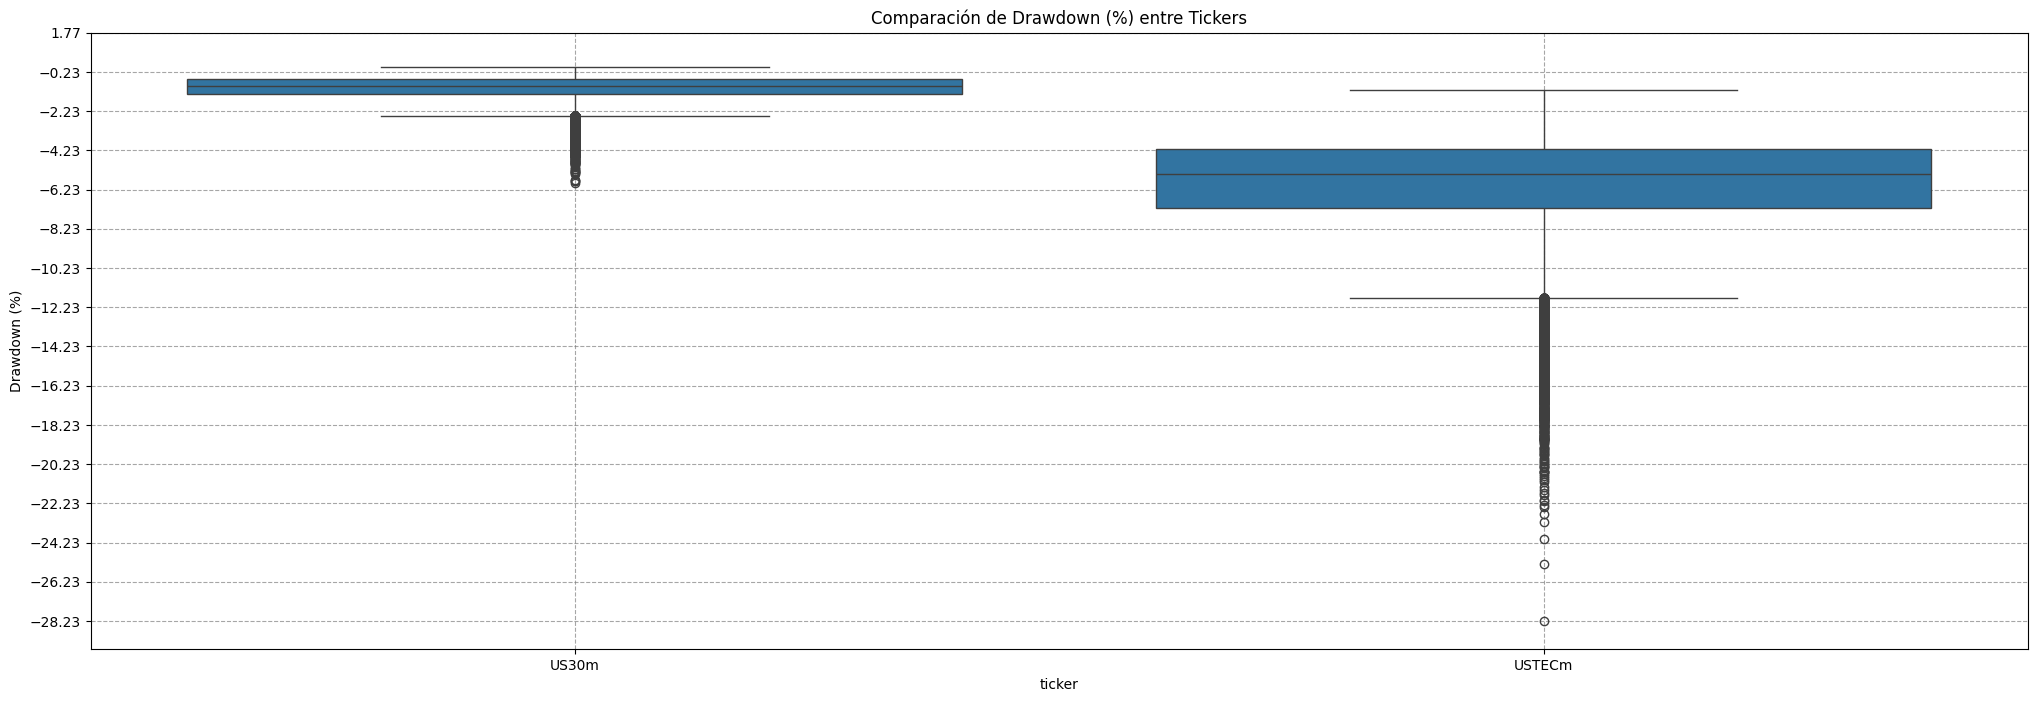

In [26]:
# Configurar el gráfico con matplotlib y seaborn
plt.figure(figsize=(25, 8))
sns.boxplot(data=dd_df, x="ticker", y="Drawdown (%)")
plt.title("Comparación de Drawdown (%) entre Tickers")

y_max = dd_df["Drawdown (%)"].max()  # Valor máximo en el eje Y
y_min = dd_df["Drawdown (%)"].min()  # Valor mínimo en el eje Y
tick_interval = 2  # Intervalo deseado entre números en el eje Y

# Configurar los ticks mayores en el eje Y
plt.yticks(np.arange(y_min, y_max + tick_interval, tick_interval))

# Activar la cuadrícula
plt.grid(True, linestyle='--', which='both', color='grey', alpha=0.7)

# Mostrar el gráfico
plt.show()

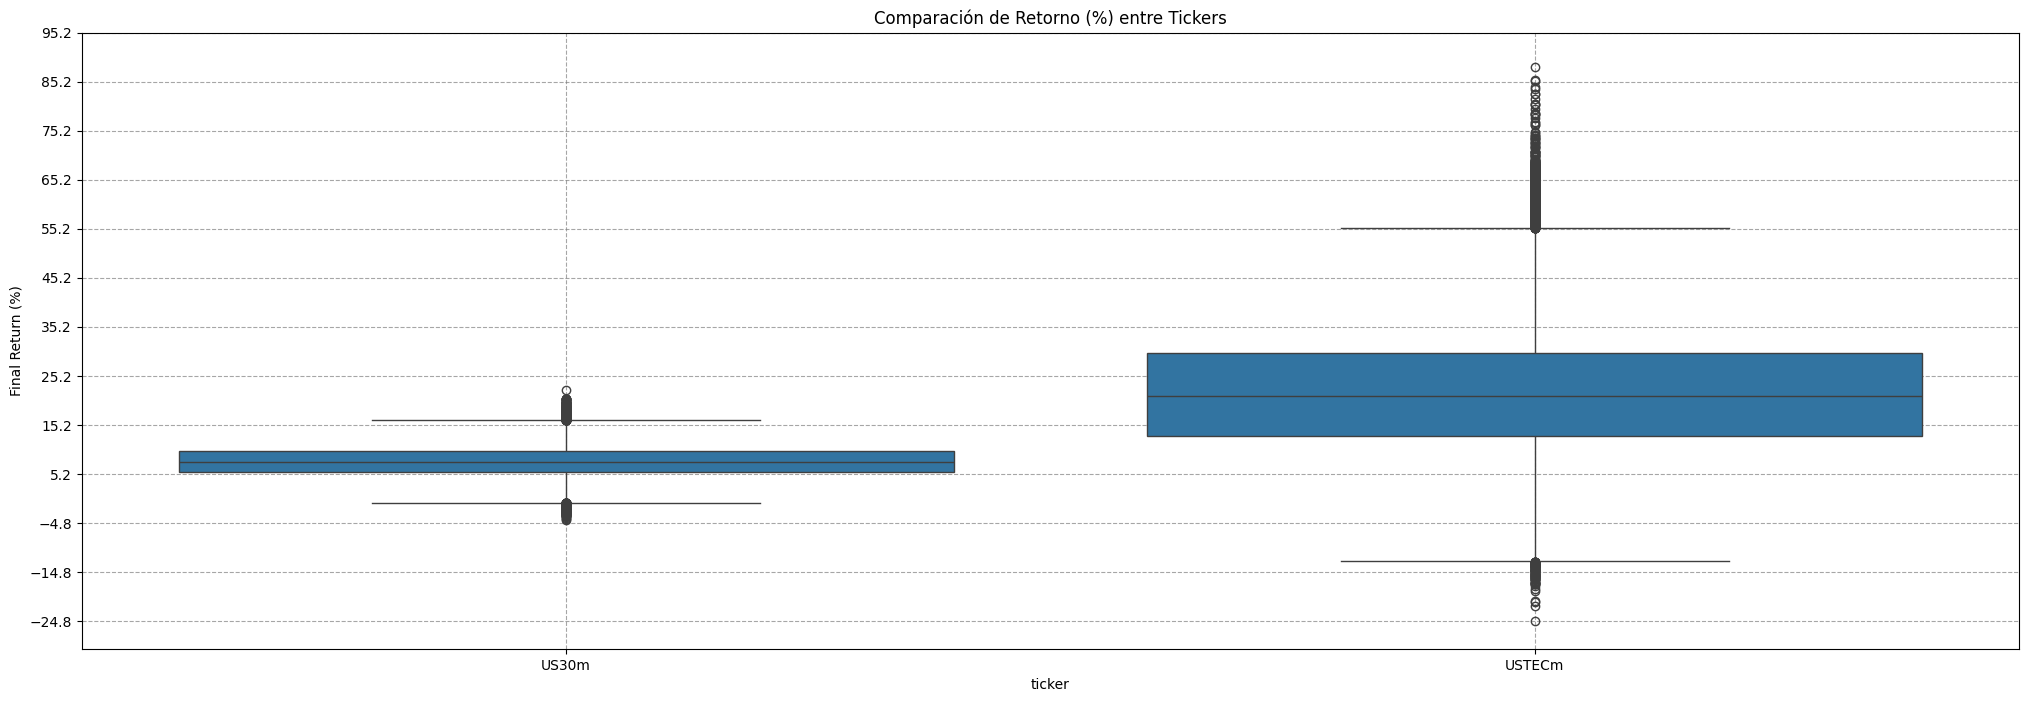

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Generar el gráfico
plt.figure(figsize=(25, 8))
sns.boxplot(data=ret_df, x="ticker", y="Final Return (%)")
plt.title("Comparación de Retorno (%) entre Tickers")

# Configurar ticks mayores con más números
y_max = ret_df["Final Return (%)"].max()  # Valor máximo en el eje Y
y_min = ret_df["Final Return (%)"].min()  # Valor mínimo en el eje Y
tick_interval = 10  # Intervalo deseado entre números en el eje Y

# Configurar los ticks mayores en el eje Y
plt.yticks(np.arange(y_min, y_max + tick_interval, tick_interval))

# Activar la cuadrícula
plt.grid(True, linestyle='--', which='both', color='grey', alpha=0.7)

# Mostrar el gráfico
plt.show()
